In [55]:
import pandas as pd
import numpy as np
import string
import re
import nltk
# nltk.download()

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support, roc_curve, auc

In [42]:
df = pd.read_csv("../data/svm_tweets/twitter_training.csv", header = None)
df = df[df[1] == "Amazon"]
df.columns = ["c0","c1","class","text"] 
# df = df.drop_duplicates(inplace = True)
n_positives = np.sum(df["class"] == "Positive")
n_negatives = np.sum(df["class"] == "Negative")
print(f"There is {n_positives} Positives AND {n_negatives} Negatives")
df = df[(df["class"] == "Positive") | (df["class"] == "Negative")]
size = 300        # sample size
replace = True  # with replacement
fn = lambda obj: obj.loc[np.random.choice(obj.index, size, replace),:]
df = df.groupby('class', as_index=False).apply(fn).reset_index()
df = df[["text","class"]]
df["text"] = df["text"].astype("str")
df["class"] = df["class"].replace(["Negative","Positive"],[0,1])
df

There is 312 Positives AND 576 Negatives


,text,class
0,"@ amazonIN @ amazon @ AmazonHelp. Also, you ca...",0
1,"Google, Amazon most imitated brand names used ...",0
2,............ Frank Please don'just t fucking f...,0
3,Hey @Bezos @Amazon @Instacart what the actual ...,0
4,"If you like it, you'll regret it",0
...,...,...
595,I saw this on that James Earl May show on Amaz...,1
596,This Revlon brush off is really that work! Lit...,1
597,For people around you which want to use Amazon...,1
598,of,1


In [45]:
#Cleaning Text
def clean_text(text):
    text_lc = "".join([word.lower() for word in text if word not in string.punctuation]) # remove puntuation
    text_rc = re.sub('[0-9]+', '', text_lc)
    tokens = re.split('\W+', text_rc)    # tokenization
    text = [ps.stem(word) for word in tokens if word not in stopword]  # remove stopwords and stemming
    return text

In [46]:
def get_probs(df, op = "1"):
    ps = nltk.PorterStemmer()
    stopword = nltk.corpus.stopwords.words('english')
    #Appliyng Countvectorizer
    if op == "1":
        countVectorizer = CountVectorizer(analyzer=clean_text) 
    elif op == "2":
        countVectorizer = TfidfVectorizer(analyzer=clean_text) 
    
    countVector = countVectorizer.fit_transform(df['text'])
    # print("{} Number of reviews has {} words".format(countVector.shape[0], countVector.shape[1]))
    #print(countVectorizer.get_feature_names())
    count_vect_df = pd.DataFrame(countVector.toarray(), columns=countVectorizer.get_feature_names())

    #calculating probs    
    X = count_vect_df.values[:,:]
    print(f'X shape: {X.shape}')
    probs = np.mean(X, axis = 0) 
    probs = pd.DataFrame({"Probs":probs})
    probs = probs.sort_values(by = "Probs", ascending=False)
    probs["probs2"] = probs["Probs"] / probs["Probs"].sum()
    probs["crf"] = probs["probs2"].cumsum()
    return count_vect_df, probs


X shape: (600, 1263)
X shape: (600, 1263)


/Users/juanolmos/opt/anaconda3/envs/dl/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


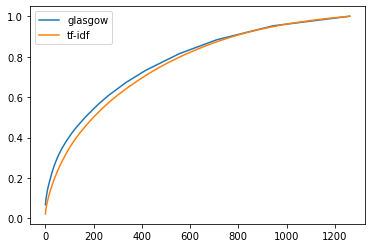

In [47]:
mop1, prosop1 = get_probs(df = df, op = "1")
mop2, prosop2 = get_probs(df = df, op = "2")
xx = np.arange(len(prosop1.crf))
plt.plot(xx,prosop1.crf, label = "glasgow")
plt.plot(xx,prosop2.crf, label = "tf-idf")
plt.legend()

In [50]:

X, y = mop1.values, df["class"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = SVC()
clf.fit(X, y)
y_pred = clf.predict(X_test)
""" 
-----   Metrics  -----
"""   
acc = accuracy_score(y_test, y_pred)
prf = precision_recall_fscore_support(y_test, y_pred,zero_division=0.0)
pre, spe, sen, f1s = prf[0][1], prf[1][0], prf[1][1], prf[2][1]

metrics_df = pd.DataFrame({'Recall': [sen],                    
                    'Precision': [pre],
                    'Accuracy': [acc],
                    'F1-Score': [f1s]})
metrics_df


,Recall,Precision,Accuracy,F1-Score
0,1.0,0.935484,0.966667,0.966667
